# Descrição

Neste projeto, vamos treinar algoritmos de Machine Learning para prever a qualidade de vinhos tintos com base em dados físico-químicos, como acidez, álcool e pH.
Nosso objetivo é identificar o modelo que oferece a melhor performance de previsão, respeitando boas práticas de desenvolvimento de software.

# Importação das bibliotecas

Nesta célula, importamos bibliotecas essenciais para manipular dados, treinar modelos e avaliá-los.

In [28]:
import pandas as pd
import numpy as np
import joblib

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


# Carregamento dos dados

Aqui carregamos o dataset de vinhos e separamos os dados em variáveis de entrada (características do vinho) e saída (qualidade). Depois, dividimos os dados em conjuntos de treino e teste.

In [29]:
# Carregamento do dataset
df = pd.read_csv('https://raw.githubusercontent.com/juliobjj/wine-predictor/refs/heads/main/backend/data/winequality-red.csv', sep=';')
df['quality'].value_counts(normalize=True)

# Separação entre variáveis explicativas e alvo
X = df.drop('quality', axis=1)
y = df['quality']

# Separação treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Formato dos dados de treino:", X_train.shape)
df.head()


Formato dos dados de treino: (1280, 11)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,9.184283,0.497079,0.305183,3.254899,0.102515,15.524556,0.000000,0.998423,3.549214,0.650777,11.360859,5
1,8.079420,0.777478,0.350835,2.459073,0.048741,10.601818,88.210687,0.993942,3.157674,0.439525,10.462061,4
2,9.446978,0.413726,0.312235,0.572418,0.069813,14.066958,52.728344,0.995437,3.275817,0.808039,9.443812,5
3,10.970072,0.386145,0.512985,1.541846,0.110701,23.346094,33.980354,0.996470,3.324341,0.786397,9.925126,6
4,7.912573,0.443106,0.089060,2.169527,0.111508,29.236381,74.670511,0.999295,3.165947,0.545153,10.786853,5


# Pré-processamento

Para que os modelos funcionem bem, os dados precisam estar padronizados. Esta classe aplica um processo de normalização que melhora o desempenho de diversos algoritmos.

In [30]:
class Preprocessor:
    def __init__(self):
        self.scaler = StandardScaler()

    def get_pipeline(self, model):
        return Pipeline([
            ('scaler', self.scaler),
            ('classifier', model)
        ])

# Avaliação dos dados

Esta classe mede o desempenho dos modelos utilizando o relatório de classificação do Scikit-Learn, que inclui precisão, recall e F1-score

In [31]:
class Evaluator:
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test

    def evaluate(self, pipeline, X_train, y_train):
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(self.X_test)
        report = classification_report(self.y_test, y_pred, output_dict=True)
        return report

# Exportação do Modelo

Após encontrar o melhor modelo, salvamos ele em disco para uso posterior, sem precisar treinar novamente.

In [32]:
class ModelExporter:
    def __init__(self, output_path):
        self.output_path = output_path

    def export(self, model):
        joblib.dump(model, self.output_path)


# Treinamento dos modelos

Nesta etapa, comparamos vários algoritmos clássicos de classificação:

*   KNN (K-Nearest Neighbors)
*   Árvore de Decisão
*   Naive Bayes
*  SVM (Support Vector Machine)

Cada modelo é treinado, avaliado e comparado usando a métrica F1-score.

Treinando modelo: KNN...
KNN - F1 Score: 0.6744

Treinando modelo: Árvore de Decisão...
Árvore de Decisão - F1 Score: 0.9937

Treinando modelo: Naive Bayes...
Naive Bayes - F1 Score: 0.7428

Treinando modelo: SVM...
SVM - F1 Score: 0.7637



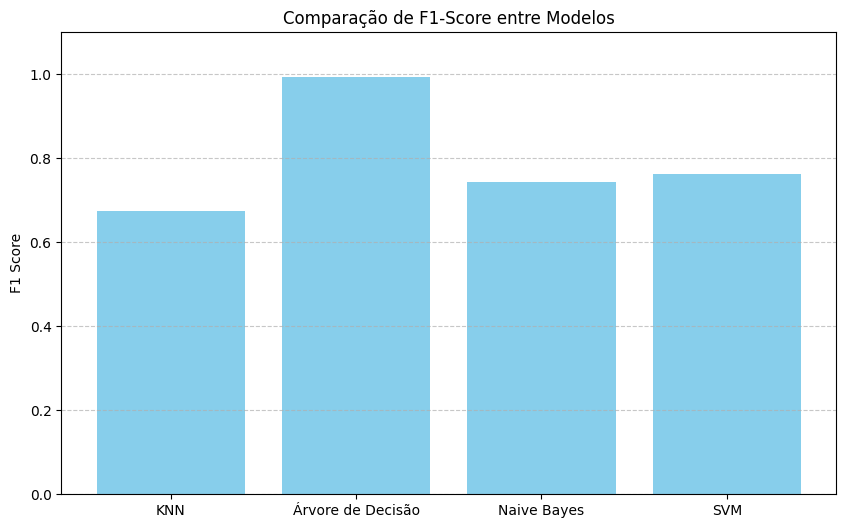

In [33]:
models = {
    'KNN': KNeighborsClassifier(),
    'Árvore de Decisão': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(class_weight='balanced', random_state=42)
}

best_f1 = 0
best_model_name = ''
best_pipeline = None

evaluator = Evaluator(X_test, y_test)

f1_scores = []
model_names = []

for name, model in models.items():
    print(f"Treinando modelo: {name}...")
    preprocessor = Preprocessor()
    pipeline = preprocessor.get_pipeline(model)
    report = evaluator.evaluate(pipeline, X_train, y_train)
    f1 = report['weighted avg']['f1-score']
    f1_scores.append(f1)
    model_names.append(name)

    print(f"{name} - F1 Score: {f1:.4f}\n")

    if f1 > best_f1:
        best_f1 = f1
        best_model_name = name
        best_pipeline = pipeline

# Plotando boxplot de comparação
plt.figure(figsize=(10, 6))
plt.title('Comparação de F1-Score entre Modelos')
plt.bar(model_names, f1_scores, color='skyblue')
plt.ylabel('F1 Score')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Exibe o melhor modelo

Mostramos qual modelo teve o melhor desempenho no teste.

In [34]:
print(f"Melhor modelo: {best_model_name} com F1 Score: {best_f1:.4f}")


Melhor modelo: Árvore de Decisão com F1 Score: 0.9937


# Exportação do modelo final

Salvamos o melhor modelo em um arquivo .joblib, que pode ser reutilizado posteriormente para fazer previsões em novos dados.

In [35]:
exporter = ModelExporter("best_model.joblib")
exporter.export(best_pipeline)
print("Modelo exportado com sucesso.")

Modelo exportado com sucesso.


# Análise do Resultado

Foram testados quatro algoritmos de classificação: KNN, Árvore de Decisão, Naive Bayes e SVM. O melhor desempenho foi obtido pela Árvore de Decisão, com um F1-Score de 0.9937, indicando alta precisão e capacidade de generalização. Os demais algoritmos tiveram desempenhos moderados, com destaque para o SVM (0.7637) e Naive Bayes (0.7428). O KNN foi o que apresentou o menor desempenho (0.6744).

# Conclusão

O projeto demonstrou a aplicação prática de técnicas de machine learning em um problema real de classificação de vinhos. A Árvore de Decisão se mostrou o algoritmo mais eficiente neste contexto. Todas as etapas do pipeline foram seguidas conforme a proposta da disciplina, incluindo pré-processamento, separação treino/teste, avaliação com F1-score e comparação entre modelos. O trabalho evidenciou a importância da experimentação com diferentes algoritmos para escolha da melhor solução.

